In [1]:
# Init workspace
!rm -r dataset
!mkdir dataset

# Download dataset and extract it
!gdown 111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V
!mv imagenet-a.tar ./dataset
!tar -xf ./dataset/imagenet-a.tar
!mv imagenet-a ./dataset

# Cleanup
!rm ./dataset/imagenet-a.tar

# (optional) Upgrading pytorch for the latest augmentation functions
#!pip install --upgrade torch torchvision torchaudio

rm: cannot remove 'dataset': No such file or directory
Downloading...
From (original): https://drive.google.com/uc?id=111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V
From (redirected): https://drive.google.com/uc?id=111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V&confirm=t&uuid=234ada6f-dcb7-4860-af2b-ab8470db0b6f
To: /content/imagenet-a.tar
100% 688M/688M [00:06<00:00, 112MB/s] 


In [2]:
# Init workspace
!rm -r dataset
!mkdir dataset

# Download dataset and extract it
!gdown 1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd
!mv imagenetv2-matched-frequency.tar.gz ./dataset
!tar -xf ./dataset/imagenetv2-matched-frequency.tar.gz
!mv imagenetv2-matched-frequency-format-val ./dataset

# Cleanup
!rm ./dataset/imagenetv2-matched-frequency.tar.gz

# (optional) Upgrading pytorch for the latest augmentation functions
#!pip install --upgrade torch torchvision torchaudio

Downloading...
From (original): https://drive.google.com/uc?id=1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd
From (redirected): https://drive.google.com/uc?id=1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd&confirm=t&uuid=e6b5c625-3c88-4553-a3b0-0115e4ad852a
To: /content/imagenetv2-matched-frequency.tar.gz
100% 1.26G/1.26G [00:13<00:00, 96.6MB/s]


In [3]:
import json
import os
from os import listdir
from os.path import basename, isfile, join
from pathlib import Path
import requests
from contextlib import nullcontext
from copy import deepcopy
from typing import Union
from PIL import Image

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision.transforms import v2
from transformers import ViTForImageClassification, ViTImageProcessor

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIZE = (224, 224)

In [5]:
def load_imagenet_v2_labels() -> list[int]:

    imagenet_v2 = "./dataset/imagenetv2-matched-frequency-format-val"

    labels = [int(f) for f in listdir(imagenet_v2) if not isfile(join(imagenet_v2, f))]
    labels.sort()

    return labels

In [6]:
def load_model_labels() -> list[str]:

    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    path = Path(basename(url))

    # Check if labels file already exists
    if not path.exists():
        response = requests.get(url)
        path.write_text(response.text)

    # Load labels
    with open(path, "r") as f:
        labels = json.load(f)

    return labels

In [7]:
def load_model(model_name: str = "google/vit-base-patch16-224") -> ViTForImageClassification:

    # Load the pre-trained model
    return ViTForImageClassification.from_pretrained(model_name).to(DEVICE)

In [8]:
class ImageNetV2(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = load_imagenet_v2_labels() * 10
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        label = idx // 10

        img_folder = os.path.join(self.img_dir, str(label))
        img_path = [join(img_folder, f) for f in listdir(img_folder) if isfile(join(img_folder, f))][idx % (label if label != 0 else 1) - 1]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [9]:
def load_dataset(resize: bool = True) -> torch.utils.data.dataloader.DataLoader:

    imagenet_v2 = "./dataset/imagenetv2-matched-frequency-format-val"

    # Prepare data transformations for the train loader
    transforms = [] if not resize else [T.Resize(SIZE)]
    transforms.append(T.ToTensor())
    transform = T.Compose(transforms)

    # Load data
    imagenet_v2_dataset = ImageNetV2(annotations_file=[], img_dir=imagenet_v2, transform=transform)
    return torch.utils.data.DataLoader(imagenet_v2_dataset, 1, shuffle=True, num_workers=8)

In [10]:
def classify(model: ViTForImageClassification, img: torch.Tensor, no_grad: bool = True) -> dict:

    # Use GPU if available
    img = img.to(DEVICE)

    # Perform inference
    model.eval()

    with torch.no_grad() if no_grad else nullcontext():
        outputs = model(img)

    # Extract probabilities from model's output logits
    results = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()

    return results

In [11]:
def elaborate_results(results: torch.Tensor) -> Union[dict, list]:

    # Load model's labels
    model_labels = load_model_labels()

    if len(results.shape) == 1:
        results = [results]

    # Process results
    final_results = []

    for result in results:

        item_results = {
            "predicted": {},
            "results": {}
        }

        predicted = None

        for index, probability in enumerate(result):

            item_results["results"][index] = {
                "index": index,
                "label": model_labels[index],
                "probability": probability.item()
            }

            if predicted is None or predicted["probability"] < probability.item():
                predicted = item_results["results"][index]

        item_results["predicted"] = predicted

        final_results.append(item_results)

    return final_results if len(final_results) > 1 else final_results[0]


In [ ]:
# # Load model (only once)
# model = load_model()

# # Load data (only once)
# data_loader = load_dataset()

# # Evaluate the model (Accuracy: 18.37 %)
# accuracy = 0

# for index, img in enumerate(data_loader):

#     # Get model prediction
#     results = classify(model=model, img=img[0])
#     results = elaborate_results(results=results)
#     predicted, results = results["predicted"], results["results"]

#     if img[1].item() == predicted["index"]:
#         accuracy = accuracy + 1

#     print(f"Image {index+1} / {len(data_loader)} | Accuracy: {round((accuracy / (index + 1)) * 100, 2)}% ({accuracy} / {index + 1})")

# accuracy = accuracy / len(data_loader)

In [15]:
import matplotlib.pyplot as plt
def show_image(img):
  plt.imshow(img.squeeze(0).permute(1, 2, 0))

In [41]:
# Supponendo che load_dataset, classify_image, merged_labels e il modello siano definiti altrove
accuracy_before = 0
accuracy_after = 0

# Load model (only once)
model = load_model()
original_model = deepcopy(model)

data_loader = load_dataset(resize=False)

# transformation = T.Compose([
#         T.Resize((500, 500)),
#         T.CenterCrop((384, 384)) ])

transforms = v2.Compose([
    v2.RandomResizedCrop(size=SIZE, antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resize_transformation = T.Compose([ T.Resize(SIZE) ])

# Salva lo stato iniziale del modello
initial_state = model.state_dict().copy()

for index, img in enumerate(data_loader):
    # Ripristina lo stato iniziale del modello
    model = deepcopy(original_model)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    # Azzera i gradienti prima di calcolare i nuovi
    optimizer.zero_grad()

    # Immagine ridimensionata (384x384)
    img1 = resize_transformation(img[0])
    # Immagini con augmentation
    img2 = transforms(img[0])
    img3 = transforms(img[0])
    img4 = transforms(img[0])

    # Concatena immagini
    imgs = [img1, img2, img3, img4]
    input = torch.cat(imgs, dim=0)

    # Classificazione dell'immagine 1 prima delle augmentation
    results = classify(model=model, img=img1)
    results = elaborate_results(results=results)
    predicted, results = results["predicted"], results["results"]

    # Aggiorna accuracy della classificazione senza augmentation
    if img[1].item() == predicted["index"]:
        accuracy_before = accuracy_before + 1

    predicted_before = predicted["label"]

    # Calcola gli output delle immagini
    output = model(input.to(DEVICE))

    # Combina le probabilità delle immagini
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1).squeeze().to(DEVICE)

    # Calcolo entropia
    marginal = torch.mean(probabilities, dim=0).to(DEVICE)
    entropy = -torch.sum(marginal * torch.log(marginal)).to(DEVICE)
    entropy.backward()

    # Gradient step
    optimizer.step()

    # Classificazione dell'immagine 1 dopo le augmentation
    results = classify(model=model, img=img1)
    results = elaborate_results(results=results)
    predicted, results = results["predicted"], results["results"]

    #print(probabilities1 == probabilities2)
    # Aggiorna accuracy della classificazione con augmentation
    if img[1].item() == predicted["index"]:
        accuracy_after = accuracy_after + 1

    label1 = f"Image {index + 1} / {len(data_loader)}"
    label2 = f"Accuracy before: {round((accuracy_before / (index + 1)) * 100, 1)}% ({accuracy_before} / {index + 1})"
    label3 = f"Accuracy after: {round((accuracy_after / (index + 1)) * 100, 1)}% ({accuracy_after} / {index + 1})"
    label4 = f"Diff: {round((accuracy_after / (index + 1)) * 100 - (accuracy_before / (index + 1)) * 100, 2)}%"

    print(f"{label1} | {label2} | {label3} | {label4}")

Image 1 / 10000 | Accuracy before: 100.0% (1 / 1) | Accuracy after: 100.0% (1 / 1) | Diff: 0.0%
Image 2 / 10000 | Accuracy before: 50.0% (1 / 2) | Accuracy after: 50.0% (1 / 2) | Diff: 0.0%
Image 3 / 10000 | Accuracy before: 66.7% (2 / 3) | Accuracy after: 66.7% (2 / 3) | Diff: 0.0%
Image 4 / 10000 | Accuracy before: 50.0% (2 / 4) | Accuracy after: 75.0% (3 / 4) | Diff: 25.0%
Image 5 / 10000 | Accuracy before: 40.0% (2 / 5) | Accuracy after: 60.0% (3 / 5) | Diff: 20.0%
Image 6 / 10000 | Accuracy before: 50.0% (3 / 6) | Accuracy after: 66.7% (4 / 6) | Diff: 16.67%
Image 7 / 10000 | Accuracy before: 42.9% (3 / 7) | Accuracy after: 71.4% (5 / 7) | Diff: 28.57%
Image 8 / 10000 | Accuracy before: 50.0% (4 / 8) | Accuracy after: 75.0% (6 / 8) | Diff: 25.0%
Image 9 / 10000 | Accuracy before: 44.4% (4 / 9) | Accuracy after: 66.7% (6 / 9) | Diff: 22.22%
Image 10 / 10000 | Accuracy before: 50.0% (5 / 10) | Accuracy after: 70.0% (7 / 10) | Diff: 20.0%


KeyboardInterrupt: 

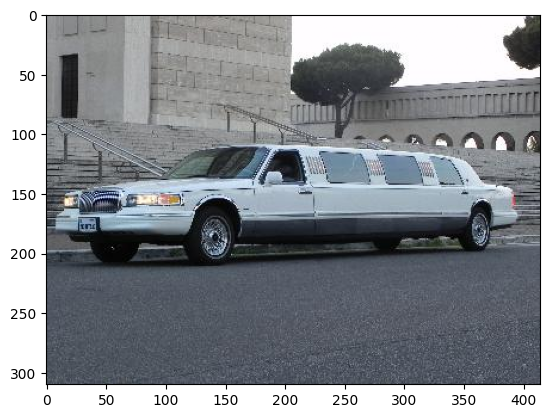

In [43]:
for image, label in data_loader:
  img = image
  break

show_image(img)

In [39]:
import skimage as sk
import numpy as np
from io import BytesIO
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom

IMG_SIZE = 224

"""helper for zoom_blur"""
def clipped_zoom(img, zoom_factor):
    h = img.shape[0]
    # ceil crop height(= crop width)
    ch = int(np.ceil(h / zoom_factor))

    top = (h - ch) // 2
    img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
    # trim off any extra pixels
    trim_top = (img.shape[0] - h) // 2

    return img[trim_top:trim_top + h, trim_top:trim_top + h]

"""helper for defocus_blur"""
def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)

def saturate(x, severity=1):
    c = [(0.3, 0), (0.1, 0), (2, 0), (5, 0.1), (20, 0.2)][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 1] = np.clip(x[:, :, 1] * c[0] + c[1], 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]

    x = x.resize((int(IMG_SIZE * c), int(IMG_SIZE * c)), PILImage.BOX)
    x = x.resize((IMG_SIZE, IMG_SIZE), PILImage.BOX)

    return x


def jpeg_compression(x, severity=1):
    c = [25, 18, 15, 10, 7][severity - 1]

    output = BytesIO()
    x.save(output, 'JPEG', quality=c)
    x = PILImage.open(output)

    return x


def brightness(x, severity=1):
    c = [.1, .2, .3, .4, .5][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def zoom_blur(x, severity=1):
    c = [np.arange(1, 1.11, 0.01),
         np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.02),
         np.arange(1, 1.26, 0.02),
         np.arange(1, 1.31, 0.03)][severity - 1]

    x = (np.array(x) / 255.).astype(np.float32)
    out = np.zeros_like(x)
    for zoom_factor in c:
        zoomed = clipped_zoom(x, zoom_factor)
        resized_zoomed = cv2.resize(zoomed, (out.shape[1], out.shape[0]))
        out += resized_zoomed

    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255


def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    for d in range(3):
        channels.append(cv2.filter2D(x[:, :, d], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x224x224 -> 224x224x3

    return np.clip(channels, 0, 1) * 255


def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def shot_noise(x, severity=1):
    c = [60, 25, 12, 5, 3][severity - 1]

    x = np.array(x) / 255.
    return np.clip(np.random.poisson(x * c) / c, 0, 1) * 255

def impulse_noise(x, severity=1):
    c = [.03, .06, .09, 0.17, 0.27][severity - 1]

    x = sk.util.random_noise(np.array(x) / 255., mode='s&p', amount=c)
    return np.clip(x, 0, 1) * 255

def speckle_noise(x, severity=1):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255

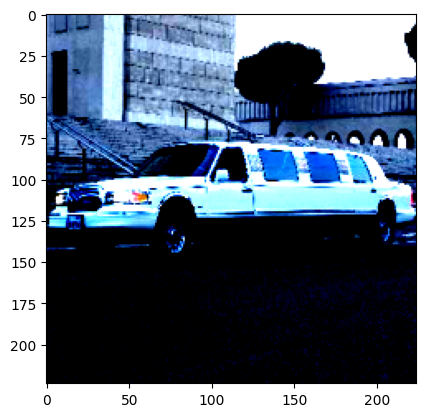

In [45]:
img1 = resize_transformation(img)
# Immagini con augmentation
img2 = transforms(img)
img3 = transforms(img)
img4 = transforms(img)

show_image(img2)

In [ ]:
image_tensor = img1*255
image_tensor = image_tensor.to(torch.uint8)  # Converti a uint8

# Conversione del tensore in array NumPy
image_np = image_tensor.numpy().transpose(0, 2, 3, 1)  # [1, 224, 224, 3]

# Applicazione della funzione gaussian_noise
noisy_image_np = gaussian_noise(image_np, severity=1)

# Conversione dell'array NumPy modificato di nuovo in tensore
noisy_image_tensor = torch.tensor(noisy_image_np, dtype=torch.uint8).permute(0, 3, 1, 2)  # [1, 3, 224, 224]

# Visualizzazione dell'immagine originale e dell'immagine con rumore
plt.figure(figsize=(10, 5))

# Immagine originale
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np[0].astype(np.uint8))

# Immagine con rumore
plt.subplot(1, 2, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image_np[0].astype(np.uint8))

plt.show()